# Imports


In [1]:
import numpy as np 
import pandas as pd 
import os

import matplotlib.pyplot as plt
import csv
import itertools
import collections

import pywt
from scipy import stats

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Conv1D, AvgPool1D, Flatten, Dense, Dropout, Softmax
from keras.layers import Input, Dense, Dropout, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Embedding, Add, MaxPool1D,ZeroPadding1D, LSTM
from keras.optimizers import Adam 
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras import regularizers
from keras.models import Sequential, Model


from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

import seaborn as sns
from sklearn.metrics import confusion_matrix


%matplotlib inline

# matplotlib Settings

In [2]:
'''
plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True 

'''

'\nplt.rcParams["figure.figsize"] = (30,6)\nplt.rcParams[\'lines.linewidth\'] = 1\nplt.rcParams[\'lines.color\'] = \'b\'\nplt.rcParams[\'axes.grid\'] = True \n\n'

# Methods Definitions

In [3]:
def denoise(data): 
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.04 # Threshold for filtering

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        
    datarec = pywt.waverec(coeffs, 'sym4')
    
    return datarec


# Variables Definitions

In [4]:
path = '/kaggle/input/mitbit-arrhythmia-database/mitbih_database/'
window_size = 180
maximum_counting = 10000

classes = ['N', 'S', 'F', 'V', 'Q']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

# Prepere Input Files

In [5]:
# Read files
filenames = next(os.walk(path))[2]

# Split and save .csv , .txt 
records = list()
annotations = list()
filenames.sort()

In [6]:
# segrefating filenames and annotations
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    
    # *.csv
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    # *.txt
    else:
        annotations.append(path + filename + file_extension)

# Data Extraction and Preprocessing

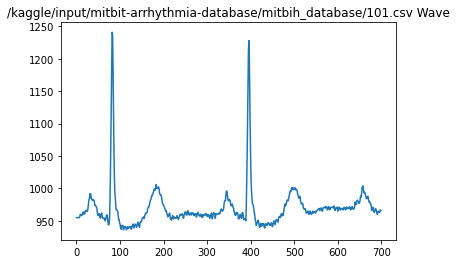

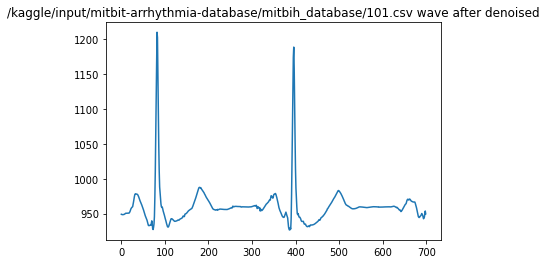

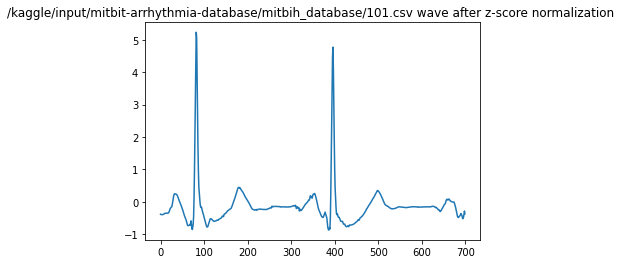

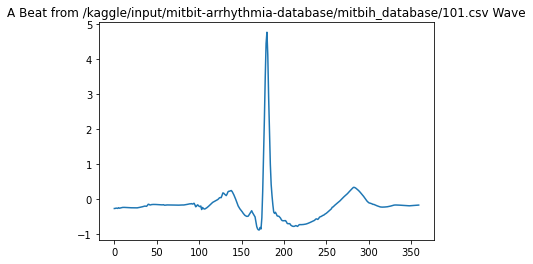

(82977, 360) (82977,)


In [7]:
# Records
for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file\
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1
            
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " Wave")
        plt.plot(signals[0:700])
        plt.show()
        
    signals = denoise(signals)
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " wave after denoised")
        plt.plot(signals[0:700])
        plt.show()
        
    signals = stats.zscore(signals)
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " wave after z-score normalization ")
        plt.plot(signals[0:700])
        plt.show()
    
    # Read anotations: R position and Arrhythmia class
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()

        for d in range(1, len(data)): # 0 index is Chart Head
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID
            arrhythmia_type = next(splitted) # Type
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
#                 if count_classes[arrhythmia_index] > maximum_counting: # avoid overfitting
#                     pass
#                 else:
                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]     ## REPLACE WITH R-PEAK DETECTION
                    # Plot an example to a beat    
                    if r is 1 and not example_beat_printed: 
                        plt.title("A Beat from " + records[1] + " Wave")
                        plt.plot(beat)
                        plt.show()
                        example_beat_printed = True

                    X.append(beat)
                    y.append(arrhythmia_index)

# data shape
print(np.shape(X), np.shape(y))


In [8]:
for i in range(0,len(X)):
        X[i] = np.append(X[i], y[i])
#         X[i].append(y[i])

print(np.shape(X))

(82977, 361)


# Classes Distribution

0.0    75011
3.0     7129
2.0      802
4.0       33
1.0        2
Name: 360, dtype: int64


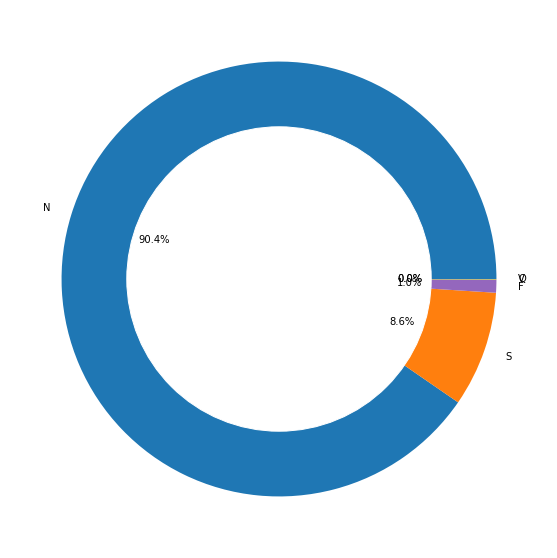

In [9]:
X_train_df = pd.DataFrame(X)
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'S', 'F', 'V', 'Q'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

# Rebalancing Classes

In [10]:
df_1=X_train_df[X_train_df[X_train_df.shape[1]-1]==1]
df_2=X_train_df[X_train_df[X_train_df.shape[1]-1]==2]
df_3=X_train_df[X_train_df[X_train_df.shape[1]-1]==3]
df_4=X_train_df[X_train_df[X_train_df.shape[1]-1]==4]
# df_5=X_train_df[X_train_df[X_train_df.shape[1]-1]==5]
df_0=(X_train_df[X_train_df[X_train_df.shape[1]-1]==0]).sample(n=5000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=5000,random_state=122)
df_2_upsample=resample(df_2,replace=True,n_samples=5000,random_state=123)
df_3_upsample=resample(df_3,replace=True,n_samples=5000,random_state=124)
df_4_upsample=resample(df_4,replace=True,n_samples=5000,random_state=125)
# df_5_upsample=resample(df_5,replace=True,n_samples=5000,random_state=126)

# X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample,df_5_upsample])
X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

4.0    5000
3.0    5000
2.0    5000
1.0    5000
0.0    5000
Name: 360, dtype: int64


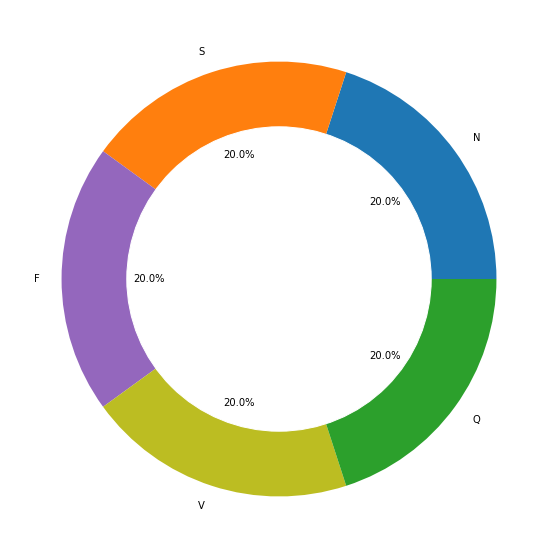

In [11]:
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'S', 'F', 'V', 'Q'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

# Train-Test Split

In [12]:
train, test = train_test_split(X_train_df, test_size=0.20)

print("X_train : ", np.shape(train))
print("X_test  : ", np.shape(test))

X_train :  (20000, 361)
X_test  :  (5000, 361)


In [13]:
target_train=train[train.shape[1]-1]
target_test=test[test.shape[1]-1]
train_y=to_categorical(target_train)
test_y=to_categorical(target_test)
print(np.shape(train_y), np.shape(test_y))

(20000, 5) (5000, 5)


In [14]:
train_x = train.iloc[:,:train.shape[1]-1].values
test_x = test.iloc[:,:test.shape[1]-1].values
train_x = train_x.reshape(len(train_x), train_x.shape[1],1)
test_x = test_x.reshape(len(test_x), test_x.shape[1],1)
print(np.shape(train_x), np.shape(test_x))

(20000, 360, 1) (5000, 360, 1)


## CNN model


In [15]:
# Instanciate an empty model
model = Sequential()

# Adding a Convolution Layer C1
# Input shape = N = (360 x 1)
# No. of filters  = 16
# Filter size = f = (13 x 1)
# Padding = true
# Strides = S = 1
# Size of each feature map in C1 is (N-f+2P)/S +1 = 360-13+2*6 +1 = 360
# No. of parameters between input layer and C1 = (13*1 + 1)*16 = 224
model.add(Conv1D(filters=16, kernel_size=13, padding='same', activation='relu',input_shape=(360, 1)))


# Adding an Average Pooling Layer S2
# Input shape = N = (360 x 16)
# No. of filters = 16
# Filter size = f = (3 x 1)
# Padding = P = 0
# Strides = S = 2
# Size of each feature map in S2 is (N-f+2P+1)/S = (360-3+0+1)/2 = 179
# No. of parameters between C1 and S2 = (1+1)*16 = 32
model.add(AvgPool1D(pool_size=3, strides=2))





# Adding a Convolution Layer C3
# Input shape = N = (179 x 16)
# No. of filters  = 32
# Filter size = f = (15 x 1)
# Padding = true
# Strides = S = 1
# Size of each feature map in C1 is (N-f+2P)/S +1 = 179-15+2*7 +1 = 360
# No. of parameters between input layer and C1 = (15*1 + 1)*32 = 512
model.add(Conv1D(filters=32, kernel_size=15, padding='same', activation='relu'))


# Adding an Average Pooling Layer S4
# Input shape = N = (179 x 32)
# No. of filters = 32
# Filter size = f = (3 x 1)
# Padding = P = 0
# Strides = S = 2
# Size of each feature map in S2 is (N-f+2P+1)/S = (179-3+0+1)/2 = 89
# No. of parameters between C1 and S2 = (1+1)*32 = 64
model.add(AvgPool1D(pool_size=3, strides=2))



# Adding a Convolution Layer C5
# Input shape = N = (89 x 32)
# No. of filters  = 64
# Filter size = f = (17 x 1)
# Padding = true
# Strides = S = 1
# Size of each feature map in C1 is (N-f+2P)/S +1 = 89-17+2*8 +1 = 89
# No. of parameters between input layer and C1 = (17*1 + 1)*64 = 1152
model.add(Conv1D(filters=64, kernel_size=17, padding='same', activation='relu'))



# Adding an Average Pooling Layer S6
# Input shape = N = (89 x 64)
# No. of filters = 64
# Filter size = f = (3 x 1)
# Padding = P = 0
# Strides = S = 2
# Size of each feature map in S2 is (N-f+2P+1)/S = (89-3+0+1)/2 = 44
# No. of parameters between C1 and S2 = (1+1)*64 = 128
model.add(AvgPool1D(pool_size=3, strides=2))



# Adding a Convolution Layer C7
# Input shape = N = (44 x 64)
# No. of filters  = 128
# Filter size = f = (19 x 1)
# Padding = true
# Strides = S = 1
# Size of each feature map in C1 is (N-f+2P)/S +1 = 44-19+2*9 +1 = 44
# No. of parameters between input layer and C1 = (19*1 + 1)*128 = 2560
model.add(Conv1D(filters=128, kernel_size=19, padding='same', activation='relu'))


# Adding an Average Pooling Layer S8
# Input shape = N = (44 x 128)
# No. of filters = 128
# Filter size = f = (3 x 1)
# Padding = P = 0
# Strides = S = 2
# Size of each feature map in S2 is (N-f+2P+1)/S = (44-3+0+1)/2 = 21
# No. of parameters between C1 and S2 = (1+1)*128 = 256
model.add(AvgPool1D(pool_size=3, strides=2))



# Flattening the layer 
# There would be 128*(21*1) = 2688 neurons
model.add(Flatten())


# Dropout the layer S9
model.add(Dropout(0.5))



# Adding a Dense layer with regularization l2(0.0001)# S10
# No. of inputs = 2688
# No. of outputs = 35
# No. of parameters = 2688 x 35 + 35 = 94115
model.add(Dense(35,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))



# Adding a Dense layer with regularization l2(0.0001)# S11
# No. of inputs = 35
# No. of outputs = 5
# No. of parameters = 35*5 + 5 = 180
model.add(Dense(5,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))



# Adding a Softmax layer S12
# No. of inputs = 5
# No. of outputs = 5
model.add(Softmax())


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 360, 16)           224       
_________________________________________________________________
average_pooling1d (AveragePo (None, 179, 16)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 179, 32)           7712      
_________________________________________________________________
average_pooling1d_1 (Average (None, 89, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 89, 64)            34880     
_________________________________________________________________
average_pooling1d_2 (Average (None, 44, 64)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 44, 128)           1

In [16]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [17]:
history_cnn = model.fit(train_x, train_y, batch_size=100, epochs=20, verbose=1, validation_data=(test_x, test_y))

Epoch 1/20
200/200 [==============================] - 7s 10ms/step - loss: 0.5836 - accuracy: 0.7964 - val_loss: 0.1863 - val_accuracy: 0.9374
Epoch 2/20
200/200 [==============================] - 1s 7ms/step - loss: 0.1750 - accuracy: 0.9429 - val_loss: 0.1363 - val_accuracy: 0.9516
Epoch 3/20
200/200 [==============================] - 2s 8ms/step - loss: 0.1335 - accuracy: 0.9545 - val_loss: 0.1014 - val_accuracy: 0.9698
Epoch 4/20
200/200 [==============================] - 1s 7ms/step - loss: 0.1152 - accuracy: 0.9622 - val_loss: 0.0927 - val_accuracy: 0.9718
Epoch 5/20
200/200 [==============================] - 1s 7ms/step - loss: 0.0893 - accuracy: 0.9713 - val_loss: 0.0866 - val_accuracy: 0.9760
Epoch 6/20
200/200 [==============================] - 1s 7ms/step - loss: 0.0778 - accuracy: 0.9764 - val_loss: 0.0759 - val_accuracy: 0.9796
Epoch 7/20
200/200 [==============================] - 1s 7ms/step - loss: 0.0763 - accuracy: 0.9763 - val_loss: 0.0673 - val_accuracy: 0.9810
Epoch

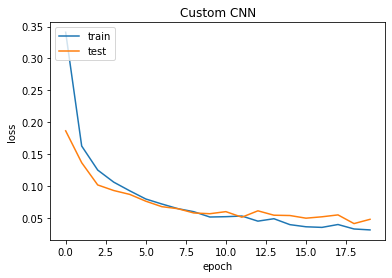

<Figure size 432x288 with 0 Axes>

In [18]:
# summarize history for loss
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('Custom CNN')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('cusCNNloss.png')

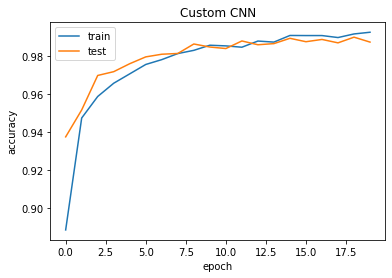

<Figure size 432x288 with 0 Axes>

In [19]:
# summarize history for accuracy
plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])
plt.title('Custom CNN')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('CustCnnAcc.png')

In [20]:
y_true=[]
for element in test_y:
    y_true.append(np.argmax(element))
prediction_proba=model.predict(test_x)
prediction=np.argmax(prediction_proba,axis=1)

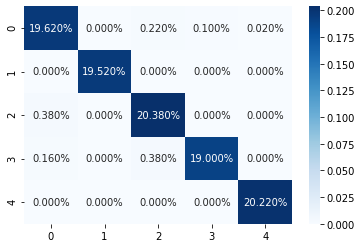

In [21]:
custCnnConfMat = confusion_matrix(y_true, prediction)
sns.heatmap(custCnnConfMat/np.sum(custCnnConfMat), annot=True,fmt='.3%', cmap='Blues')
plt.savefig('custCnnconfMat.png')

In [22]:
print('Precision: %.3f' % precision_score(y_true, prediction, average='micro'))
print('F1 Score: %.3f' % f1_score(y_true, prediction, average='micro'))
print('Recall: %.3f' % recall_score(y_true, prediction, average='micro'))
print('Accuracy: %.3f' % accuracy_score(y_true, prediction))


Precision: 0.987
F1 Score: 0.987
Recall: 0.987
Accuracy: 0.987


# ALEX-NET

In [23]:
alexNet_model=Sequential()

alexNet_model.add(Conv1D(filters=96, activation='relu', kernel_size=11, strides=4, input_shape=(360,1)))
alexNet_model.add(BatchNormalization())
alexNet_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

alexNet_model.add(Conv1D(filters=256, kernel_size=5, padding='same', activation='relu'))
alexNet_model.add(BatchNormalization())
alexNet_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

alexNet_model.add(Conv1D(filters=384, padding='same', kernel_size=3, activation='relu'))
alexNet_model.add(Conv1D(filters=384, kernel_size=3, activation='relu'))
alexNet_model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
alexNet_model.add(BatchNormalization())
alexNet_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

alexNet_model.add(Flatten())
alexNet_model.add(Dense(4096, activation='relu'))
alexNet_model.add(Dropout(0.4))
alexNet_model.add(Dense(4096, activation='relu'))
alexNet_model.add(Dropout(0.4))
alexNet_model.add(Dense(5, activation='softmax'))

In [24]:
alexNet_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 88, 96)            1152      
_________________________________________________________________
batch_normalization (BatchNo (None, 88, 96)            384       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 44, 96)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 44, 256)           123136    
_________________________________________________________________
batch_normalization_1 (Batch (None, 44, 256)           1024      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 22, 256)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 22, 384)          

In [25]:
alexNet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
alexNet_model_history = alexNet_model.fit(train_x, train_y, epochs = 20, batch_size = 100, validation_data = (test_x, test_y))

Epoch 1/20
200/200 [==============================] - 5s 18ms/step - loss: 0.9482 - accuracy: 0.8402 - val_loss: 3.6254 - val_accuracy: 0.2764
Epoch 2/20
200/200 [==============================] - 3s 17ms/step - loss: 0.1277 - accuracy: 0.9605 - val_loss: 0.5304 - val_accuracy: 0.7266
Epoch 3/20
200/200 [==============================] - 3s 17ms/step - loss: 0.1129 - accuracy: 0.9631 - val_loss: 0.0711 - val_accuracy: 0.9734
Epoch 4/20
200/200 [==============================] - 3s 17ms/step - loss: 0.0877 - accuracy: 0.9736 - val_loss: 1.0784 - val_accuracy: 0.8892
Epoch 5/20
200/200 [==============================] - 3s 17ms/step - loss: 0.1168 - accuracy: 0.9644 - val_loss: 0.1632 - val_accuracy: 0.9382
Epoch 6/20
200/200 [==============================] - 3s 17ms/step - loss: 0.0767 - accuracy: 0.9731 - val_loss: 0.1028 - val_accuracy: 0.9728
Epoch 7/20
200/200 [==============================] - 3s 17ms/step - loss: 0.0645 - accuracy: 0.9782 - val_loss: 0.0771 - val_accuracy: 0.9724

In [27]:
y_true_alexnet=[]
for element in test_y:
    y_true_alexnet.append(np.argmax(element))
prediction_proba=alexNet_model.predict(test_x)
prediction_alexnet=np.argmax(prediction_proba,axis=1)

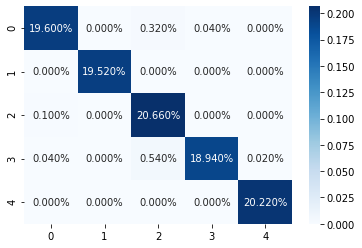

In [29]:
alexnetConfMat = confusion_matrix(y_true_alexnet, prediction_alexnet)
sns.heatmap(alexnetConfMat/np.sum(alexnetConfMat), annot=True,fmt='.3%', cmap='Blues')
plt.savefig('custCnnconfMat.png')

In [30]:
print('Precision: %.3f' % precision_score(y_true_alexnet, prediction_alexnet, average='micro'))
print('F1 Score: %.3f' % f1_score(y_true_alexnet, prediction_alexnet, average='micro'))
print('Recall: %.3f' % recall_score(y_true_alexnet, prediction_alexnet, average='micro'))
print('Accuracy: %.3f' % accuracy_score(y_true_alexnet, prediction_alexnet))


Precision: 0.989
F1 Score: 0.989
Recall: 0.989
Accuracy: 0.989


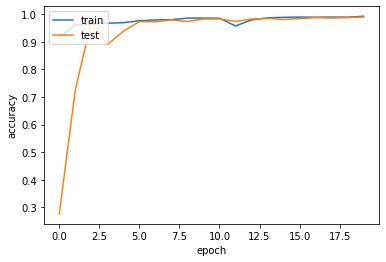

<Figure size 432x288 with 0 Axes>

In [31]:
plt.plot(alexNet_model_history.history['accuracy'])
plt.plot(alexNet_model_history.history['val_accuracy'])
#plt.title('Custom CNN')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('AlexNetAccuracy.png')

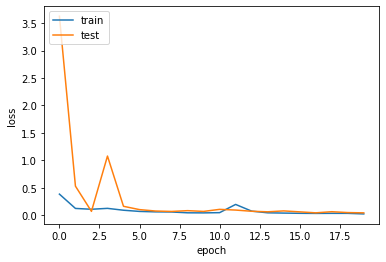

<Figure size 432x288 with 0 Axes>

In [32]:
plt.plot(alexNet_model_history.history['loss'])
plt.plot(alexNet_model_history.history['val_loss'])
#plt.title('Custom CNN')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('AlexNetLoss.png')

# VGG-16

In [33]:
vgg_16_model=Sequential()

vgg_16_model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu',  input_shape=(360,1)))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

vgg_16_model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

vgg_16_model.add(Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

vgg_16_model.add(Conv1D(filters=512, kernel_size=3, activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Conv1D(filters=512, kernel_size=3, activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Conv1D(filters=512, kernel_size=3, activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

vgg_16_model.add(Conv1D(filters=512, kernel_size=3, activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Conv1D(filters=512, kernel_size=1, activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Conv1D(filters=512, kernel_size=1, activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

vgg_16_model.add(Flatten())
vgg_16_model.add(Dense(4096, activation='relu'))
vgg_16_model.add(Dropout(0.4))
vgg_16_model.add(Dense(4096, activation='relu'))
vgg_16_model.add(Dropout(0.4))
vgg_16_model.add(Dense(5, activation='softmax'))

In [34]:
vgg_16_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 360, 64)           256       
_________________________________________________________________
batch_normalization_3 (Batch (None, 360, 64)           256       
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 360, 64)           12352     
_________________________________________________________________
batch_normalization_4 (Batch (None, 360, 64)           256       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 180, 64)           0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 180, 128)          24704     
_________________________________________________________________
batch_normalization_5 (Batch (None, 180, 128)         

In [35]:
vgg_16_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [36]:
vgg_16_model_history = vgg_16_model.fit(train_x, train_y, epochs = 20, batch_size = 100, validation_data = (test_x, test_y))

Epoch 1/20
200/200 [==============================] - 16s 62ms/step - loss: 1.8282 - accuracy: 0.8201 - val_loss: 2.0750 - val_accuracy: 0.3618
Epoch 2/20
200/200 [==============================] - 12s 60ms/step - loss: 0.1245 - accuracy: 0.9628 - val_loss: 1.5692 - val_accuracy: 0.6382
Epoch 3/20
200/200 [==============================] - 12s 59ms/step - loss: 0.1038 - accuracy: 0.9697 - val_loss: 0.2000 - val_accuracy: 0.9406
Epoch 4/20
200/200 [==============================] - 12s 60ms/step - loss: 0.0915 - accuracy: 0.9716 - val_loss: 0.0777 - val_accuracy: 0.9738
Epoch 5/20
200/200 [==============================] - 12s 61ms/step - loss: 0.0869 - accuracy: 0.9743 - val_loss: 0.0872 - val_accuracy: 0.9742
Epoch 6/20
200/200 [==============================] - 12s 61ms/step - loss: 0.0686 - accuracy: 0.9819 - val_loss: 0.0930 - val_accuracy: 0.9760
Epoch 7/20
200/200 [==============================] - 12s 60ms/step - loss: 0.0719 - accuracy: 0.9789 - val_loss: 0.0881 - val_accuracy:

In [37]:
y_true_vgg=[]
for element in test_y:
    y_true_vgg.append(np.argmax(element))
prediction_proba=vgg_16_model.predict(test_x)
prediction_vgg16=np.argmax(prediction_proba,axis=1)

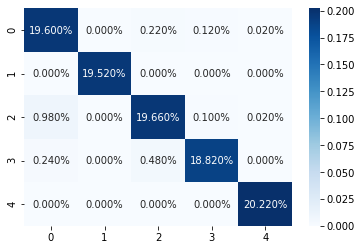

In [38]:
vggconfmat = confusion_matrix(y_true_vgg, prediction_vgg16)
sns.heatmap(vggconfmat/np.sum(vggconfmat), annot=True,fmt='.3%', cmap='Blues')
plt.savefig('vgg16ConfMat.png')

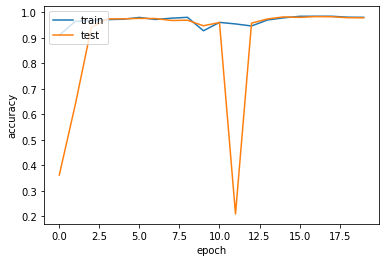

<Figure size 432x288 with 0 Axes>

In [39]:
# summarize history for accuracy
plt.plot(vgg_16_model_history.history['accuracy'])
plt.plot(vgg_16_model_history.history['val_accuracy'])
#plt.title('Custom CNN')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('vgg16Accuracy.png')

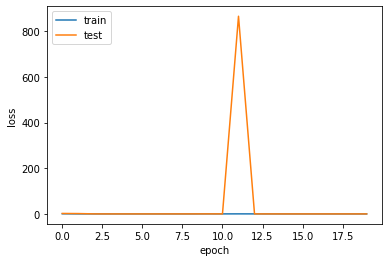

<Figure size 432x288 with 0 Axes>

In [40]:
plt.plot(vgg_16_model_history.history['loss'])
plt.plot(vgg_16_model_history.history['val_loss'])
#plt.title('Custom CNN')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('vgg16Loss.png')

# ResNet

In [41]:
def identity_block(X, f, filters):
    F1, F2, F3 = filters
    
    X_shortcut = X
    
    X = Conv1D(filters = F1, kernel_size = 1, activation='relu', strides = 1, padding = 'valid')(X)
    X = BatchNormalization()(X)
    
    X = Conv1D(filters = F2, kernel_size = f, activation='relu', strides = 1, padding = 'same')(X)
    X = BatchNormalization()(X)

    X = Conv1D(filters = F3, kernel_size = 1, activation='relu', strides = 1, padding = 'valid')(X)
    X = BatchNormalization()(X)

    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [42]:
def convolutional_block(X, f, filters, s = 2):
    F1, F2, F3 = filters
    
    X_shortcut = X

    X = Conv1D(F1, 1, activation='relu', strides = s)(X)
    X = BatchNormalization()(X)
    
    X = Conv1D(F2, f, activation='relu', strides = 1,padding = 'same')(X)
    X = BatchNormalization()(X)

    X = Conv1D(F3, 1, strides = 1)(X)
    X = BatchNormalization()(X)

    X_shortcut = Conv1D(F3, 1, strides = s)(X_shortcut)
    X_shortcut = BatchNormalization()(X_shortcut)
    
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [43]:
def ResNet50(input_shape = (360,1)):
    
    X_input = Input(input_shape)

    X = ZeroPadding1D(3)(X_input)
    
    X = Conv1D(64, 7, activation='relu', strides = 2)(X)
    X = BatchNormalization()(X)
    X = MaxPool1D(pool_size=2, strides=2, padding='same')(X)

    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

    X = convolutional_block(X, f = 3, filters = [128,128,512], s = 2)
    X = identity_block(X, 3, [128,128,512])
    X = identity_block(X, 3, [128,128,512])
    X = identity_block(X, 3, [128,128,512])

    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    X = MaxPool1D(pool_size=2, strides=2, padding='same')(X)
    
    X = Flatten()(X)
    X = Dense(5,activation='softmax')(X)
    
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [44]:
resNet50_model = ResNet50(input_shape = (360,1))

In [45]:
resNet50_model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 360, 1)]     0                                            
__________________________________________________________________________________________________
zero_padding1d (ZeroPadding1D)  (None, 366, 1)       0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_22 (Conv1D)              (None, 180, 64)      512         zero_padding1d[0][0]             
__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, 180, 64)      256         conv1d_22[0][0]                  
___________________________________________________________________________________________

In [46]:
resNet50_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [48]:
resNet50_model_history = resNet50_model.fit(train_x, train_y, epochs = 20, batch_size = 100, validation_data = (test_x, test_y))

Epoch 1/20
200/200 [==============================] - 40s 124ms/step - loss: 2.8786 - accuracy: 0.5660 - val_loss: 14.2694 - val_accuracy: 0.1968
Epoch 2/20
200/200 [==============================] - 23s 115ms/step - loss: 0.6238 - accuracy: 0.9064 - val_loss: 3.5581 - val_accuracy: 0.4898
Epoch 3/20
200/200 [==============================] - 23s 114ms/step - loss: 0.4176 - accuracy: 0.9494 - val_loss: 0.1753 - val_accuracy: 0.9390
Epoch 4/20
200/200 [==============================] - 23s 114ms/step - loss: 0.1113 - accuracy: 0.9682 - val_loss: 0.0772 - val_accuracy: 0.9750
Epoch 5/20
200/200 [==============================] - 23s 114ms/step - loss: 0.0617 - accuracy: 0.9797 - val_loss: 0.1378 - val_accuracy: 0.9630
Epoch 6/20
200/200 [==============================] - 23s 114ms/step - loss: 0.1351 - accuracy: 0.9741 - val_loss: 0.0631 - val_accuracy: 0.9820
Epoch 7/20
200/200 [==============================] - 23s 115ms/step - loss: 0.0508 - accuracy: 0.9845 - val_loss: 0.0575 - val_a

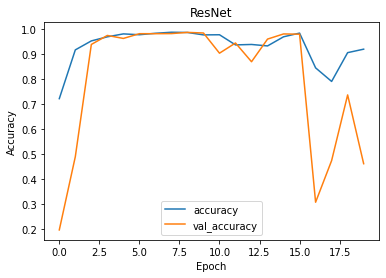

In [49]:
plt.plot(resNet50_model_history.history['accuracy'])
plt.plot(resNet50_model_history.history['val_accuracy'])
plt.legend(["accuracy","val_accuracy"])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('ResNet')
plt.savefig('ResNetAccuracy.png')

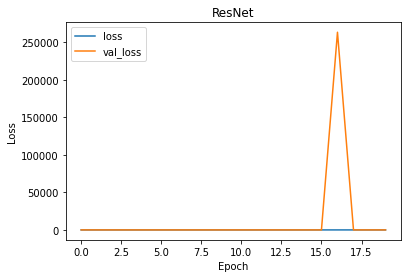

In [50]:
plt.plot(resNet50_model_history.history['loss'])
plt.plot(resNet50_model_history.history['val_loss'])
plt.legend(["loss","val_loss"])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ResNet')
plt.savefig('ResNetLoss.png')

In [81]:
y_true_resnet=[]
for element in test_y:
    y_true_resnet.append(np.argmax(element))
prediction_proba=resNet50_model.predict(test_x)
prediction_resnet=np.argmax(prediction_proba,axis=1)

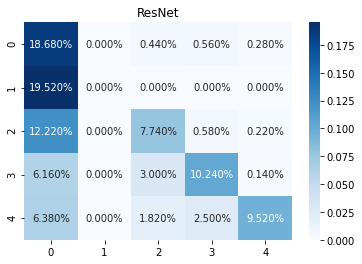

In [82]:
resNet50_model_cf_matrix = confusion_matrix(y_true_resnet, prediction_resnet)
sns.heatmap(resNet50_model_cf_matrix/np.sum(resNet50_model_cf_matrix), annot=True,fmt='.3%', cmap='Blues')
plt.title('ResNet')
plt.savefig('ResNetConfMat.png')

In [58]:
print('Precision: %.3f' % precision_score(y_true_resnet, prediction_resnet, average='micro'))
print('F1 Score: %.3f' % f1_score(y_true_resnet, prediction_resnet, average='micro'))
print('Recall: %.3f' % recall_score(y_true_resnet, prediction_resnet, average='micro'))
print('Accuracy: %.3f' % accuracy_score(y_true_resnet, prediction_resnet))

Precision: 0.978
F1 Score: 0.978
Recall: 0.978
Accuracy: 0.978


# LSTM

In [59]:
lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(360,1)))
lstm_model.add(Dense(128, activation = 'relu'))
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(5, activation = 'softmax'))

In [60]:
lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                16896     
_________________________________________________________________
dense_9 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 645       
Total params: 25,861
Trainable params: 25,861
Non-trainable params: 0
_________________________________________________________________


In [61]:
lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [62]:
lstm_model_history = lstm_model.fit(train_x, train_y, epochs = 20, batch_size = 100, validation_data = (test_x, test_y))

Epoch 1/20
200/200 [==============================] - 6s 22ms/step - loss: 1.4198 - accuracy: 0.3499 - val_loss: 1.3033 - val_accuracy: 0.4668
Epoch 2/20
200/200 [==============================] - 4s 18ms/step - loss: 1.2649 - accuracy: 0.4716 - val_loss: 0.9861 - val_accuracy: 0.6214
Epoch 3/20
200/200 [==============================] - 4s 20ms/step - loss: 1.0136 - accuracy: 0.5991 - val_loss: 1.6266 - val_accuracy: 0.3878
Epoch 4/20
200/200 [==============================] - 4s 19ms/step - loss: 1.2983 - accuracy: 0.4766 - val_loss: 1.3887 - val_accuracy: 0.3956
Epoch 5/20
200/200 [==============================] - 4s 18ms/step - loss: 1.3382 - accuracy: 0.3982 - val_loss: 1.4869 - val_accuracy: 0.3496
Epoch 6/20
200/200 [==============================] - 4s 18ms/step - loss: 1.3549 - accuracy: 0.4191 - val_loss: 1.1022 - val_accuracy: 0.5604
Epoch 7/20
200/200 [==============================] - 4s 19ms/step - loss: 1.1294 - accuracy: 0.5428 - val_loss: 1.0164 - val_accuracy: 0.5624

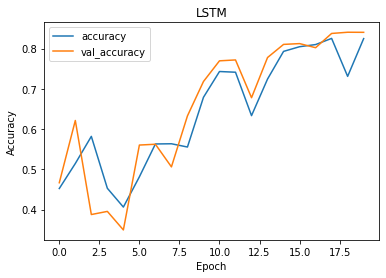

In [63]:
plt.plot(lstm_model_history.history['accuracy'])
plt.plot(lstm_model_history.history['val_accuracy'])
plt.legend(["accuracy","val_accuracy"])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('LSTM')
plt.savefig('LSTMaccuracy.png')

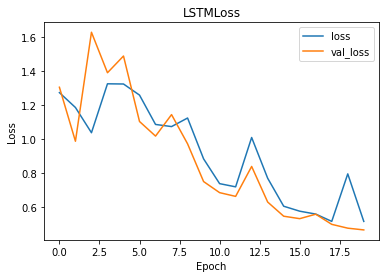

In [64]:
plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])
plt.legend(["loss","val_loss"])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LSTMLoss')
plt.savefig('LSTMLoss.png')

In [65]:
y_true_lstm=[]
for element in test_y:
    y_true_lstm.append(np.argmax(element))
prediction_proba=lstm_model.predict(test_x)
prediction_lstm=np.argmax(prediction_proba,axis=1)

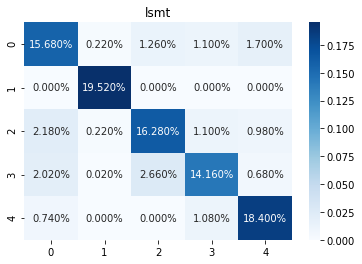

In [66]:
lstmconfmat = confusion_matrix(y_true_lstm, prediction_lstm)
sns.heatmap(lstmconfmat/np.sum(lstmconfmat), annot=True,fmt='.3%', cmap='Blues')
plt.title('lsmt')
plt.savefig('lstm.png')

# Lenet

In [71]:
lenet_5_model=Sequential()

lenet_5_model.add(Conv1D(filters=6, kernel_size=3, padding='same', activation='relu', input_shape=(360,1)))
lenet_5_model.add(BatchNormalization())
lenet_5_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

lenet_5_model.add(Conv1D(filters=16, strides=1, kernel_size=5, activation='relu'))
lenet_5_model.add(BatchNormalization())
lenet_5_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

lenet_5_model.add(Flatten())

lenet_5_model.add(Dense(64, activation='relu'))

lenet_5_model.add(Dense(32, activation='relu'))

lenet_5_model.add(Dense(5, activation = 'softmax'))

In [72]:
lenet_5_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_77 (Conv1D)           (None, 360, 6)            24        
_________________________________________________________________
batch_normalization_71 (Batc (None, 360, 6)            24        
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 180, 6)            0         
_________________________________________________________________
conv1d_78 (Conv1D)           (None, 176, 16)           496       
_________________________________________________________________
batch_normalization_72 (Batc (None, 176, 16)           64        
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 88, 16)            0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1408)             

In [73]:
lenet_5_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [74]:
lenet_5_model_history = lenet_5_model.fit(train_x, train_y, epochs = 20, batch_size = 100, validation_data = (test_x, test_y))

Epoch 1/20
200/200 [==============================] - 2s 6ms/step - loss: 0.4079 - accuracy: 0.8660 - val_loss: 1.0202 - val_accuracy: 0.6684
Epoch 2/20
200/200 [==============================] - 1s 5ms/step - loss: 0.0930 - accuracy: 0.9668 - val_loss: 0.1688 - val_accuracy: 0.9678
Epoch 3/20
200/200 [==============================] - 1s 5ms/step - loss: 0.0616 - accuracy: 0.9779 - val_loss: 0.0745 - val_accuracy: 0.9752
Epoch 4/20
200/200 [==============================] - 1s 5ms/step - loss: 0.0441 - accuracy: 0.9852 - val_loss: 0.0634 - val_accuracy: 0.9776
Epoch 5/20
200/200 [==============================] - 1s 5ms/step - loss: 0.0354 - accuracy: 0.9882 - val_loss: 0.0539 - val_accuracy: 0.9814
Epoch 6/20
200/200 [==============================] - 1s 6ms/step - loss: 0.0305 - accuracy: 0.9901 - val_loss: 0.0496 - val_accuracy: 0.9866
Epoch 7/20
200/200 [==============================] - 1s 5ms/step - loss: 0.0226 - accuracy: 0.9934 - val_loss: 0.0499 - val_accuracy: 0.9822
Epoch 

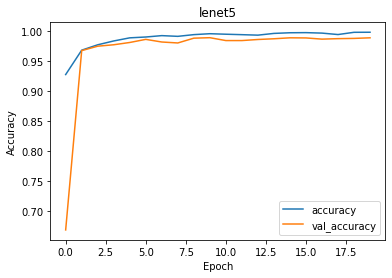

In [75]:
plt.plot(lenet_5_model_history.history['accuracy'])
plt.plot(lenet_5_model_history.history['val_accuracy'])
plt.legend(["accuracy","val_accuracy"])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('lenet5')
plt.savefig('Lenet5Accuracy.png')

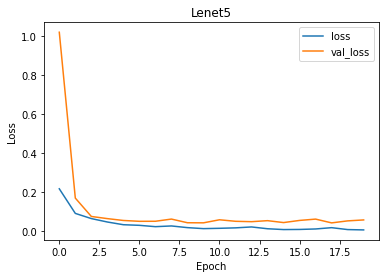

In [76]:
plt.plot(lenet_5_model_history.history['loss'])
plt.plot(lenet_5_model_history.history['val_loss'])
plt.legend(["loss","val_loss"])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Lenet5')
plt.savefig('Lenet5Loss.png')

In [77]:
y_true_lenet=[]
for element in test_y:
    y_true_lenet.append(np.argmax(element))
prediction_proba=lenet_5_model.predict(test_x)
prediction_lenet=np.argmax(prediction_proba,axis=1)

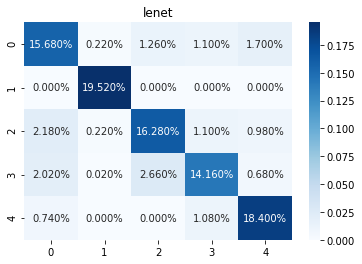

In [78]:
lenetconfmat = confusion_matrix(y_true_lenet, prediction_lenet)
sns.heatmap(lstmconfmat/np.sum(lstmconfmat), annot=True,fmt='.3%', cmap='Blues')
plt.title('lenet')
plt.savefig('lenet.png')